### Постановка задачи (задача достижимости)
Дан граф $G $; $ℒ$ - контекстно-свободный язык

Требуется найти $R' =  \{(v_i, v_j)| w(v_i \pi v_j) \in L\}$

В данном эксперименте исследуется задача достижимости между всеми парами вершин используя алгоритм Хеллингса, матричный алгоритм, тензорный алгоритм и алгоритм на основе GLL.

В ходе данного эксперимента будут рассмотрены следующие вопросы, на которые будут получены ответы:

- Какой из трёх указанных алгоритмов обладает лучшей производительностью?

- Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

- Как влияет грамматика на производительность тензорного алгоритма и алгоритма на основе GLL? Если зафиксировать язык, то как свойства грамматики (размер, (не)однозначность) влияют на производительность.

### Описание исследуемых решений
Для решения исследуемых задач были реализованы следующие методы:

- Алгоритм Хеллингса: Перед началом работы алгоритма, грамматика переводится в обобщённую нормальную форму Хомского (далее ОНФХ). Отдельно храним не рассмотренные ребра. Каждое нерассмотренное ребро проверяем на порождаемость со смежными; в случае успеха, сохраняем данную пару ребер вместе с соответствующим нетерминалом. (алгоритм в какой-то степени напоминает алгоритм Флойда для нахождения транзитивного замыкания) 

- Матричный алгоритм: Перед началом работы алгоритма, грамматика переводится в ОНФХ. Строим матрицу смежности графа, элементами которой будут множества нетерминалов из которых выводимы пути между соответствующими вершинами. До тех пор, пока матрица не перестанет меняться, прибавляем к ней её квадрат

- Тензорный алгоритм: Перед началом работы алгоритма, по грамматике (необязательно в ОНФХ) строится рекурсивный конечный автомат (далее RSM). Далее строится пересечение RSM и графа с использованием тензорного произведения, по этому пересечению строится транзитивное замыкание, ребра которого добавляются в графах. Процесс повторяется до тех пор, пока мы не перестанем находить новые ребра 

- Алгоритм на основе GLL: Перед началом работы алгоритма, по грамматике (необязательно в ОНФХ) строится RSM. Алгоритм анализирует граф, начиная с начальных состояний автомата, и обрабатывает терминальные и нетерминальные переходы для нахождения достижимых пар узлов. В процессе используется граф синтаксического анализа (далее GSS), который строится рекурсивно, с учетом всех возможных переходов, пока не будут найдены все пары узлов, которые соответствуют стартовым и конечным условиям задачи.

В качестве алгоритма для решения задачи достижмости с регулярными ограничениями был выбран `tensor_based_rpq`, который оказался более производительным исходя из результатов эксперемента №1 (задача 5) 

### Описание вычислительной машины

- Processor	12th Gen Intel(R) Core(TM) i7-12700H   2.30 GHz
- Installed RAM	16.0 GB (15.7 GB usable)
- System type 64-bit operating system, x64-based processor

### Описание используемого ПО

- Операционная система Linux Mint 22
- Python 3.12.7

### Окружение

- Необходимые зависимости указаны в `req_experiment.txt`

### Импорты

In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import time
import cfpq_data
import warnings
import networkx as nx
from collections import Counter

import project.adjacency_matrix_fa
from pyformlang.cfg import CFG
from pyformlang.regular_expression import Regex
from scipy.sparse import SparseEfficiencyWarning

from project.cfpq_hellings import hellings_based_cfpq
from project.matrix_cfpq import matrix_based_cfpq
from project.tensor_cfpq import cfg_to_rsm
from project.gll_cfpq import gll_based_cfpq
from project.graph_lib import get_graph_info_by_name, get_graph_by_name

import sources directory


Отключить <INFO> логи, ворнинги

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)
cfpq_data.logging.disable()

### Окружение

- Необходимые зависимости указаны в `req_experiment.txt`

### Описание набора данных для экспериментов

#### Графы

Для эксперемента были выбраны следующие графы из `CFPQ_Data`

1.   RDF-графы: funding, skos
2.   Графы языка C: bzip,wc 
3.   Граф языка Java: lusearch

Выбор обусловлен желанием провести эксперемент на графах из разных областей. Не были рассмотрены графы больше `core` (за исключением) `lusearch`, поскольку при имеющемся оборудовании, замеры занимали слишком мнгого времени

Информация о количестве вершин и ребер представлена на графике:

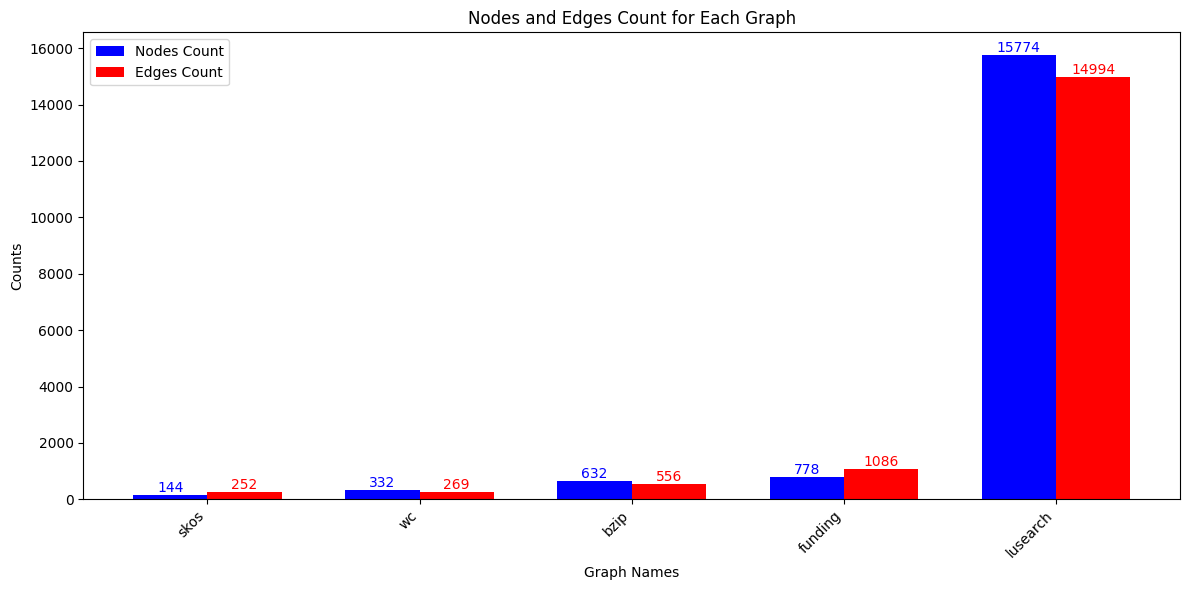

In [5]:
experiment_graphs = [
    "skos",
    "wc",
    "bzip",
    "funding",
    "lusearch",
]

graph_names = []
node_counts = []
edge_counts = []

for graph_name in experiment_graphs:
    graph_info = get_graph_info_by_name(graph_name)
    graph_names.append(graph_name)
    node_counts.append(graph_info.nodes_count)
    edge_counts.append(graph_info.edges_count)

x = range(len(graph_names))

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
nodes_bar = ax.bar(
    x, node_counts, width=bar_width, label="Nodes Count", color="b", align="center"
)
edges_bar = ax.bar(
    [i + bar_width for i in x],
    edge_counts,
    width=bar_width,
    label="Edges Count",
    color="r",
    align="center",
)

ax.set_xlabel("Graph Names")
ax.set_ylabel("Counts")
ax.set_title("Nodes and Edges Count for Each Graph")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(graph_names, rotation=45, ha="right")
ax.legend()

for i, (node_count, edge_count) in enumerate(zip(node_counts, edge_counts)):
    ax.text(
        x[i], node_count + 0.05, str(node_count), ha="center", va="bottom", color="b"
    )
    ax.text(
        x[i] + bar_width,
        edge_count + 0.05,
        str(edge_count),
        ha="center",
        va="bottom",
        color="r",
    )

plt.tight_layout()
plt.show()


def init_graphs(names: list[str]) -> list[nx.Graph]:
    graphs = []
    for name in names:
        graph = get_graph_by_name(name)
        cfpq_data.graphs.add_reverse_edges(graph)
        graph.name = name
        graphs.append(graph)
    return graphs


GRAPHS_RDF = init_graphs(["skos", "funding"])
GRAPHS_C = init_graphs(["bzip", "wc"])
GRAPHS_JAVA = init_graphs(["lusearch"])

GRAPHS: list[nx.Graph] = sorted(
    GRAPHS_RDF + GRAPHS_C + GRAPHS_JAVA, key=lambda g: g.number_of_edges()
)

graph_names = ["skos", "funding", "bzip", "wc", "lusearch"]

#### Запросы

Для каждого графа были выбраны следующие КС-запросы:


*   Для графов RDF
    <pre>
    *   S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
    *   S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
    *   S -> type_r S type | type_r type
    </pre>

*   Для графов языка C
    <pre>
    S -> d_r V d
    V -> V1 V2 V3
    V1 -> epsilon
    V1 -> V2 a_r V1
    V2 -> epsilon
    V2 -> S
    V3 -> epsilon
    V3 -> a V2 V3
    </pre>

*   Для графов языка Java
    <pre>
    S -> PTh alloc
    PTh -> epsilon
    PTh -> assign PTh
    PTh -> load_0 Al store_0 PTh
    PTh -> load_1 Al store_1 PTh
    FT -> alloc_r FTh
    FTh -> epsilon
    FTh -> assign_r FTh
    FTh -> store_0_r Al load_0_r FTh
    FTh -> store_1_r Al load_1_r FTh
    Al -> S FT
    </pre>

Для ответа на второй вопрос были выбраны следующие регулярные запросы:

1. `(l1 | l2)* l3`
2. `(l3 | l4)+ l1*`
3. `l1 l2 l3 (l4|l1)*`
4. `(l1 l2) | l2*`

In [6]:
rdf_cfg = [
    CFG.from_text("""
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
    """),
    CFG.from_text("""
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
    """),
    CFG.from_text("""
        S -> type_r S type | type_r type
    """),
]

c_cfg = [
    CFG.from_text("""
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
    """)
]

java_cfg = [
    CFG.from_text("""
        S -> PTh alloc
        PTh -> epsilon
        PTh -> assign PTh
        PTh -> load_0 Al store_0 PTh
        PTh -> load_1 Al store_1 PTh
        FT -> alloc_r FTh
        FTh -> epsilon
        FTh -> assign_r FTh
        FTh -> store_0_r Al load_0_r FTh
        FTh -> store_1_r Al load_1_r FTh
        Al -> S FT
    """)
]


def build_most_common_labels(four_frequent_labels):
    l1 = str(four_frequent_labels[0])
    l2 = str(four_frequent_labels[1])
    l3 = str(four_frequent_labels[2])
    l4 = str(four_frequent_labels[3])
    reg_exps = [
        Regex(f"({l1}|{l2})* {l3}"),
        Regex(f"({l3}|{l4})+ {l1}*"),
        Regex(f"{l1} {l2} {l3} ({l4}|{l1})*"),
        Regex(f"({l1}{l2})| {l2}*"),
    ]
    return [(reg_exp, reg_exp.to_cfg()) for reg_exp in reg_exps]

### Описание эксперимента

- Для ответа на первый вопрос для графа из каждой группы, запускаем все 4 алгоритма на каждом из выбранных запросов. Количество запусков $-$ 20, из которых бралось среднее время работы и стандартное отклонение.

- Для ответа на второй вопрос, для каждого графа два выбранных алгоритма запускаются на каждом регулярном выражении. Алгоритмы также запускаются 20 раз, чтобы получить среднее время выполнения для каждого количества стартовых вершин.

- Для ответа на третий вопрос, выбранные грамматики преобразуются в более больше и неоднозначные, далее процесс аналогичен ответу на первый вопрос $-$ алгоритмы по 20 раз запускаются на каждом графе и каждом запросе, берется среднее время работы и стандартное отклонение. Результат сравнивается с результатом первого вопроса.

Шаги, замеры, анализ результатов и вывод для этих вопросов будут указаны далее 

# Вопрос 1 Какой из трёх указанных алгоритмов обладает лучшей производительностью?

Сделаем вышеуказанные замеры:

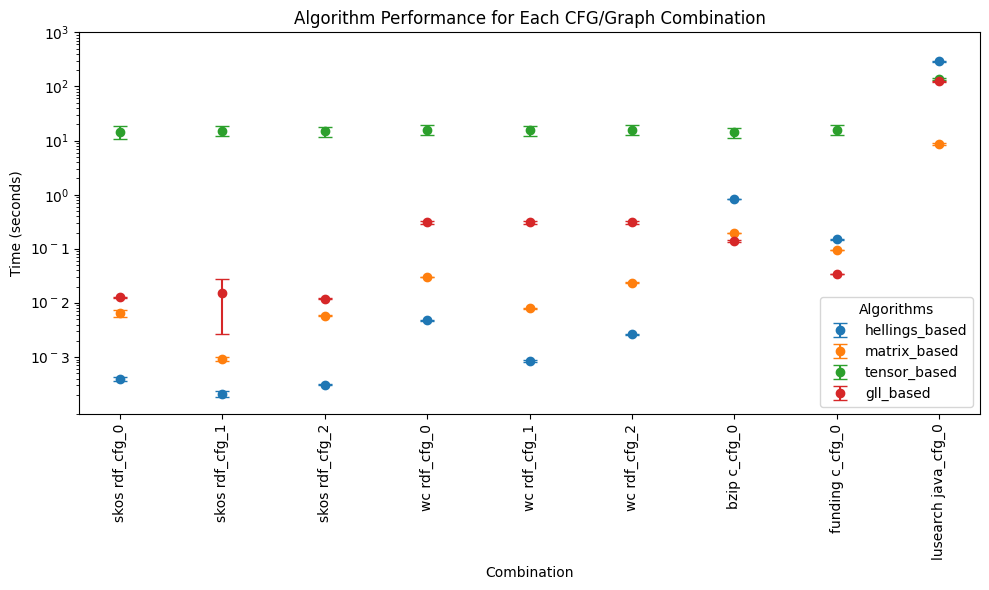

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def run_algorithms(cfg, graph, start_nodes={}, final_nodes={}):
    results = {}

    start = time.perf_counter()
    results["hellings_based"] = hellings_based_cfpq(
        cfg, graph, start_nodes, final_nodes
    )
    results["hellings_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["matrix_based"] = matrix_based_cfpq(cfg, graph, start_nodes, final_nodes)
    results["matrix_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["tensor_based"] = tensor_based_cfpq(
        cfg_to_rsm(cfg), graph, start_nodes, final_nodes
    )
    results["tensor_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["gll_based"] = gll_based_cfpq(
        cfg_to_rsm(cfg), graph, start_nodes, final_nodes
    )
    results["gll_based_time"] = time.perf_counter() - start

    return results


combinations = [
    (rdf_cfg[0], GRAPHS_RDF[0], "skos rdf_cfg_0"),
    (rdf_cfg[1], GRAPHS_RDF[0], "skos rdf_cfg_1"),
    (rdf_cfg[2], GRAPHS_RDF[0], "skos rdf_cfg_2"),
    (rdf_cfg[0], GRAPHS_RDF[1], "wc rdf_cfg_0"),
    (rdf_cfg[1], GRAPHS_RDF[1], "wc rdf_cfg_1"),
    (rdf_cfg[2], GRAPHS_RDF[1], "wc rdf_cfg_2"),
    (c_cfg[0], GRAPHS_C[0], "bzip c_cfg_0"),
    (c_cfg[0], GRAPHS_C[1], "funding c_cfg_0"),
    (java_cfg[0], GRAPHS_JAVA[0], "lusearch java_cfg_0"),
]

results_dict = {}

num_runs = 20

for cfg, graph, name in combinations:
    all_results = {
        algorithm: []
        for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]
    }

    for _ in range(num_runs):
        result = run_algorithms(cfg, graph)

        for algorithm in all_results.keys():
            all_results[algorithm].append(result.get(f"{algorithm}_time", None))

    avg_std_results = {
        algorithm: {
            "average": np.mean(all_results[algorithm]),
            "std_dev": np.std(all_results[algorithm]),
        }
        for algorithm in all_results.keys()
    }

    results_dict[name] = avg_std_results

data = []
for name, result in results_dict.items():
    for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]:
        data.append(
            {
                "Combination": name,
                "Algorithm": algorithm,
                "Average Time (seconds)": result[algorithm]["average"],
                "Std Dev (seconds)": result[algorithm]["std_dev"],
            }
        )

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]:
    algorithm_data = df[df["Algorithm"] == algorithm]
    plt.errorbar(
        algorithm_data["Combination"],
        algorithm_data["Average Time (seconds)"],
        yerr=algorithm_data["Std Dev (seconds)"],
        fmt="o",
        label=algorithm,
        capsize=5,
        markersize=6,
    )

plt.xlabel("Combination")
plt.ylabel("Time (seconds)")
plt.title("Algorithm Performance for Each CFG/Graph Combination")
plt.yscale("log")
plt.yticks([10**i for i in range(-3, 4)], [f"$10^{i}$" for i in range(-3, 4)])
plt.xticks(rotation=90)
plt.legend(title="Algorithms")
plt.tight_layout()
plt.show()

### Результаты и анализ
Для графов меньших размеров: `skos` и `wc`, лучше всего себя показали матричный алгоритм и алгоритм Хеллингса, на средних графах (`bzip` и `funding`) лучше всего справились матричный алгоритм и алгоритм на основе gll, однако на графах большего размера лучшую производительность показал матричный алгоритм. 

Результаты, полученные для меньших и средних графов, могут быть объяснены тем, что существенно большую часть времени могла занять инициализация булевой декомпозиции.

В общих чертах, матричный алгоритм обладает большей производительностью из 4-х рассматриваемых.

# Вопрос 2 Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

Для ответа на данный вопрос список графов был немного изменен в связи с нехваткой меток у `wc` и `bzip`, которые как следствие были заменены на `atom` и `generations`. 

В качестве `CFPQ` алгоритма был выбран матричный как наиболее производительный по результатам ответа на предыдущий вопрос.

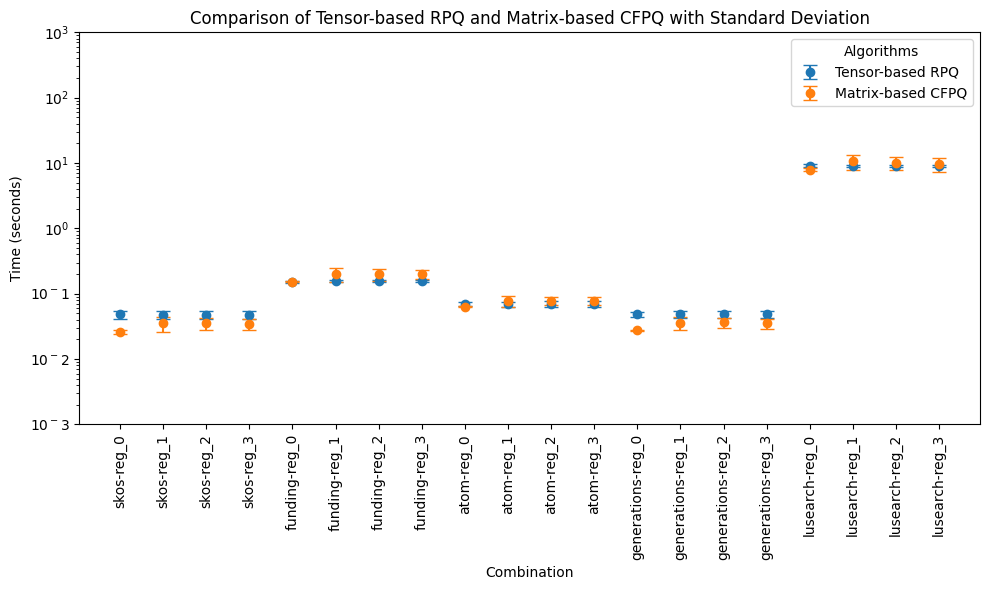

In [8]:
def run_algorithms_rpq_cfpq(cfg, graph, start_nodes={}, final_nodes={}):
    results = {}

    start = time.perf_counter()
    results["tensor_based"] = tensor_based_rpq(
        str(cfg), graph, start_nodes, final_nodes
    )
    results["tensor_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["matrix_based"] = matrix_based_cfpq(cfg, graph, start_nodes, final_nodes)
    results["matrix_based_time"] = time.perf_counter() - start

    return results


def regex_from_graph(graph_name):
    graph = get_graph_by_name(graph_name)
    most_common_labels = Counter(
        list(map(lambda node: node[2]["label"], graph.edges.data()))
    ).most_common(4)
    labels = [pair[0] for pair in most_common_labels]
    return build_most_common_labels(labels)


graph_names = ["skos", "funding", "atom", "generations", "lusearch"]
num_runs = 20

results_dict = {}

for graph_name in graph_names:
    count = 0
    regexes = regex_from_graph(graph_name)

    all_times = {"tensor_based": [], "matrix_based": []}

    for reg, cfg in regexes:
        for _ in range(num_runs):
            result = run_algorithms_rpq_cfpq(cfg, get_graph_by_name(graph_name))
            all_times["tensor_based"].append(result["tensor_based_time"])
            all_times["matrix_based"].append(result["matrix_based_time"])

        tensor_avg = np.mean(all_times["tensor_based"])
        tensor_std = np.std(all_times["tensor_based"])

        matrix_avg = np.mean(all_times["matrix_based"])
        matrix_std = np.std(all_times["matrix_based"])

        results_dict[f"{graph_name}-reg_{count}"] = {
            "tensor_based_avg": tensor_avg,
            "tensor_based_std": tensor_std,
            "matrix_based_avg": matrix_avg,
            "matrix_based_std": matrix_std,
        }

        count += 1

data = []
for name, result in results_dict.items():
    data.append(
        {
            "Combination": name,
            "Algorithm": "Tensor-based RPQ",
            "Average Time (seconds)": result["tensor_based_avg"],
            "Std Dev (seconds)": result["tensor_based_std"],
        }
    )
    data.append(
        {
            "Combination": name,
            "Algorithm": "Matrix-based CFPQ",
            "Average Time (seconds)": result["matrix_based_avg"],
            "Std Dev (seconds)": result["matrix_based_std"],
        }
    )

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))

for algorithm in ["Tensor-based RPQ", "Matrix-based CFPQ"]:
    algorithm_data = df[df["Algorithm"] == algorithm]
    plt.errorbar(
        algorithm_data["Combination"],
        algorithm_data["Average Time (seconds)"],
        yerr=algorithm_data["Std Dev (seconds)"],
        fmt="o",
        label=algorithm,
        capsize=5,
        markersize=6,
    )

plt.xlabel("Combination")
plt.ylabel("Time (seconds)")
plt.title(
    "Comparison of Tensor-based RPQ and Matrix-based CFPQ with Standard Deviation"
)
plt.yscale("log")
plt.yticks([10**i for i in range(-3, 4)], [f"$10^{i}$" for i in range(-3, 4)])
plt.xticks(rotation=90)
plt.legend(title="Algorithms")
plt.tight_layout()
plt.show()

### Результаты и анализ
Как видно из диаграмы, матричный алгоритм для КС-запросов оказался более производительным нежели специализированный тензорный алгоритм для регулярных запросов. 

Поэтому нету смысла использовать специализированные алгоритмы для регулярных запросов, когда есть более общие и производительные алгоритмы для КС-запросов

# Вопрос 3

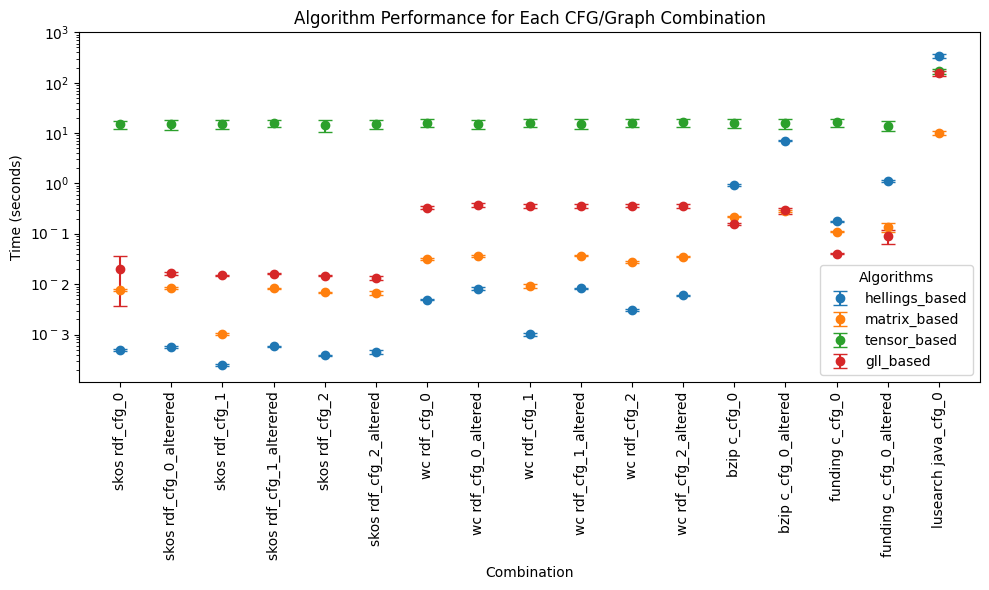

In [9]:
rdf_cfg_altered = [
    CFG.from_text("""
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type | subClassOf_r S subClassOf subClassOf | type_r S type subClassOf
    """),
    CFG.from_text("""
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type | subClassOf_r S subClassOf subClassOf | type_r S type subClassOf | type_r subClassOf subClassOf_r type
    """),
    CFG.from_text("""
        S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type | type_r type subClassOf | subClassOf_r S type
    """),
]

c_cfg_altered = [
    CFG.from_text("""
        S -> d_r V d | V d | d_r V d V
        V -> V1 V2 V3 | V1 V2 V3 V
        V1 -> epsilon | V2 a_r V1 | a_r V1
        V2 -> epsilon | S | V3
        V3 -> epsilon | a V2 V3 | V1 a_r V3
    """)
]

java_cfg_altered = [
    CFG.from_text("""
        S -> PTh alloc | PTh assign | PTh load_0 Al store_0 PTh | PTh load_1 Al store_1 PTh | PTh store_0_r Al load_0_r FTh | PTh load_0 Al store_0 PTh load_1 Al store_1 PTh
        PTh -> epsilon | assign PTh | load_0 Al store_0 PTh | load_1 Al store_1 PTh | assign assign PTh | assign load_0 Al store_0 PTh
        FT -> alloc_r FTh | assign_r FTh | store_0_r Al load_0_r FTh | store_1_r Al load_1_r FTh | alloc_r FTh store_1_r Al load_1_r FTh
        FTh -> epsilon | assign_r FTh | store_0_r Al load_0_r FTh | store_1_r Al load_1_r FTh | load_0_r FTh store_0_r Al
        Al -> S FT | load_0 Al store_0 Al | load_1 Al store_1 Al | assign_r Al
    """)
]


def run_algorithms(cfg, graph, start_nodes={}, final_nodes={}):
    results = {}

    start = time.perf_counter()
    results["hellings_based"] = hellings_based_cfpq(
        cfg, graph, start_nodes, final_nodes
    )
    results["hellings_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["matrix_based"] = matrix_based_cfpq(cfg, graph, start_nodes, final_nodes)
    results["matrix_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["tensor_based"] = tensor_based_cfpq(
        cfg_to_rsm(cfg), graph, start_nodes, final_nodes
    )
    results["tensor_based_time"] = time.perf_counter() - start

    start = time.perf_counter()
    results["gll_based"] = gll_based_cfpq(
        cfg_to_rsm(cfg), graph, start_nodes, final_nodes
    )
    results["gll_based_time"] = time.perf_counter() - start

    return results


combinations = [
    (rdf_cfg[0], GRAPHS_RDF[0], "skos rdf_cfg_0"),
    (rdf_cfg_altered[0], GRAPHS_RDF[0], "skos rdf_cfg_0_alterered"),
    (rdf_cfg[1], GRAPHS_RDF[0], "skos rdf_cfg_1"),
    (rdf_cfg_altered[1], GRAPHS_RDF[0], "skos rdf_cfg_1_alterered"),
    (rdf_cfg[2], GRAPHS_RDF[0], "skos rdf_cfg_2"),
    (rdf_cfg_altered[2], GRAPHS_RDF[0], "skos rdf_cfg_2_altered"),
    (rdf_cfg[0], GRAPHS_RDF[1], "wc rdf_cfg_0"),
    (rdf_cfg_altered[0], GRAPHS_RDF[1], "wc rdf_cfg_0_altered"),
    (rdf_cfg[1], GRAPHS_RDF[1], "wc rdf_cfg_1"),
    (rdf_cfg_altered[1], GRAPHS_RDF[1], "wc rdf_cfg_1_altered"),
    (rdf_cfg[2], GRAPHS_RDF[1], "wc rdf_cfg_2"),
    (rdf_cfg_altered[2], GRAPHS_RDF[1], "wc rdf_cfg_2_altered"),
    (c_cfg[0], GRAPHS_C[0], "bzip c_cfg_0"),
    (c_cfg_altered[0], GRAPHS_C[0], "bzip c_cfg_0_altered"),
    (c_cfg[0], GRAPHS_C[1], "funding c_cfg_0"),
    (c_cfg_altered[0], GRAPHS_C[1], "funding c_cfg_0_altered"),
    (java_cfg[0], GRAPHS_JAVA[0], "lusearch java_cfg_0"),
]

results_dict = {}

num_runs = 20

for cfg, graph, name in combinations:
    all_results = {
        algorithm: []
        for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]
    }

    for _ in range(num_runs):
        result = run_algorithms(cfg, graph)

        for algorithm in all_results.keys():
            all_results[algorithm].append(result.get(f"{algorithm}_time", None))

    avg_std_results = {
        algorithm: {
            "average": np.mean(all_results[algorithm]),
            "std_dev": np.std(all_results[algorithm]),
        }
        for algorithm in all_results.keys()
    }

    results_dict[name] = avg_std_results

data = []
for name, result in results_dict.items():
    for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]:
        data.append(
            {
                "Combination": name,
                "Algorithm": algorithm,
                "Average Time (seconds)": result[algorithm]["average"],
                "Std Dev (seconds)": result[algorithm]["std_dev"],
            }
        )

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

for algorithm in ["hellings_based", "matrix_based", "tensor_based", "gll_based"]:
    algorithm_data = df[df["Algorithm"] == algorithm]
    plt.errorbar(
        algorithm_data["Combination"],
        algorithm_data["Average Time (seconds)"],
        yerr=algorithm_data["Std Dev (seconds)"],
        fmt="o",
        label=algorithm,
        capsize=5,
        markersize=6,
    )

plt.xlabel("Combination")
plt.ylabel("Time (seconds)")
plt.title("Algorithm Performance for Each CFG/Graph Combination")
plt.yscale("log")
plt.yticks([10**i for i in range(-3, 4)], [f"$10^{i}$" for i in range(-3, 4)])
plt.xticks(rotation=90)
plt.legend(title="Algorithms")
plt.tight_layout()
plt.show()

### Результаты и анализ
Как видно из диаграмы, результаты оказались хуже чем в первом вопросе. Таким образом, при увеличении размера грамматики и (тем самым) повышении её неоднозначности, производительность ухудшается, так как появляется больше нетерминалов и правил, которые нужно обрабатывать.

В частных случая неоднозначность может помочь, например, с неоднозначной грамматикой `S -> A S1 | eps | A B; S1 -> S S2; S2 -> B S` мы раньше найдем путь в графе `0 -[A]> 1 -[B]> 2` из `0` в `2` нежели с однозначной грамматикой `S -> A S1 | eps; S1 -> S S2; S2 -> B S`. Однако, в общем случае, производительность будет меньше при увеличении размеров и неоднозначности грамматики